<a href="https://colab.research.google.com/github/Reddragonemperor58/SS-VAE/blob/main/SS_VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%tensorflow_version 2.x
import tensorflow as tf

import IPython
import functools
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm


 !pip install mitdeeplearning
import mitdeeplearning as mdl

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 14.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for mitdeeplearning: filename=mitdeeplearning-0.3.0-py3-none-any.whl size=2117302 sha256=f5d2c7ef84fc1e8511bb84aec9499dbb6371dfb267b3e1318d30d90536cd0f0c
  Stored in directory: /root/.cache/pip/wheels/9c/9f/b5/0e31f83bc60a83625e37429f923934e26802d0d68cf3ef3216
Successfully built mitdeeplearning


In [2]:
path_to_training_data = tf.keras.utils.get_file('train_face.h5', 'https://www.dropbox.com/s/hlz8atheyozp1yx/train_face.h5?dl=1')
loader = mdl.lab2.TrainingDatasetLoader(path_to_training_data)


1263889489/1263889489 [==============================] - 11s 0us/step
Opening /root/.keras/datasets/train_face.h5
Loading data into memory...


In [3]:
number_of_training_examples = loader.get_train_size()
(images, labels) = loader.get_batch(100)

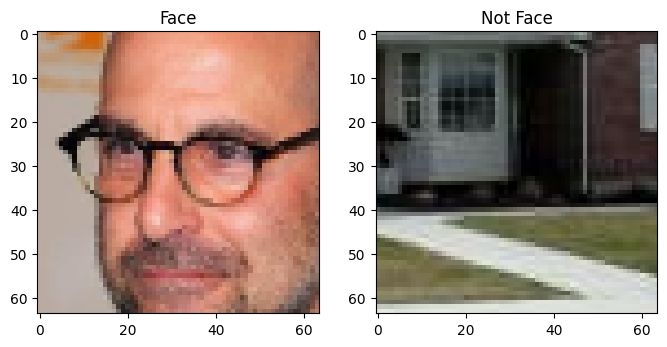

In [10]:
face_images = images[np.where(labels==1)[0]]
not_face_images = images[np.where(labels==0)[0]]

idx_face = 26 #@param {type:"slider", min:0, max:50, step:1}
idx_not_face = 24 #@param {type:"slider", min:0, max:50, step:1}

plt.figure(figsize=(8,4))
plt.subplot(1, 2, 1)
plt.imshow(face_images[idx_face])
plt.title("Face"); plt.grid(False)

plt.subplot(1, 2, 2)
plt.imshow(not_face_images[idx_not_face])
plt.title("Not Face"); plt.grid(False)

In [7]:
n_filters = 12
def make_standard_classifier(n_outputs=1):
  Conv2D = functools.partial(tf.keras.layers.Conv2D, padding='same', activation='relu')
  BatchNormalization = tf.keras.layers.BatchNormalization
  Flatten = tf.keras.layers.Flatten
  Dense = functools.partial(tf.keras.layers.Dense, activation='relu')

  model = tf.keras.Sequential([
    Conv2D(filters=1*n_filters, kernel_size=5,  strides=2),
    BatchNormalization(),

    Conv2D(filters=2*n_filters, kernel_size=5,  strides=2),
    BatchNormalization(),

    Conv2D(filters=4*n_filters, kernel_size=3,  strides=2),
    BatchNormalization(),

    Conv2D(filters=6*n_filters, kernel_size=3,  strides=2),
    BatchNormalization(),

    Flatten(),
    Dense(512),
    Dense(n_outputs, activation=None),
  ])
  return model

standard_classifier = make_standard_classifier()

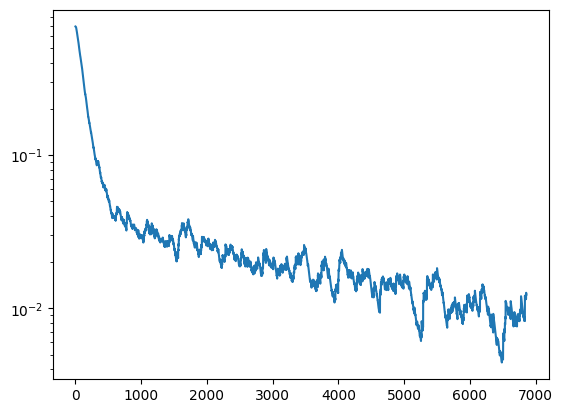

100%|██████████| 3434/3434 [05:26<00:00, 10.52it/s]


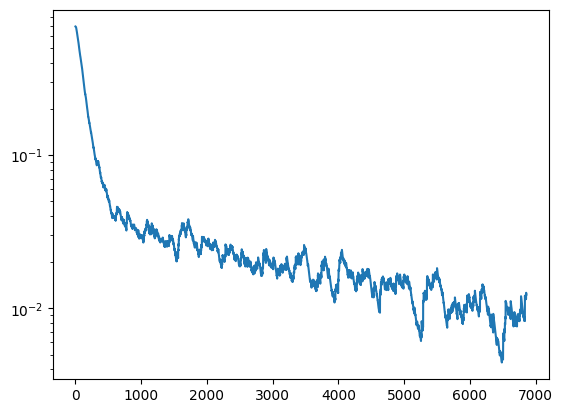

In [8]:
batch_size = 32
num_epochs = 2
learning_rate = 5e-4

optimizer = tf.keras.optimizers.Adam(learning_rate)
loss_history = mdl.util.LossHistory(smoothing_factor=0.99)
plotter = mdl.util.PeriodicPlotter(sec=2, scale='semilogy')
if hasattr(tqdm, '_instances'): tqdm._instances.clear()

@tf.function
def standard_train_step(x, y):
  with tf.GradientTape() as tape:
    logits = standard_classifier(x)
    loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=logits)

  grads = tape.gradient(loss, standard_classifier.trainable_variables)
  optimizer.apply_gradients(zip(grads, standard_classifier.trainable_variables))
  return loss

for epoch in range(num_epochs):
  for idx in tqdm(range(loader.get_train_size()//batch_size)):
    x, y = loader.get_batch(batch_size)
    loss = standard_train_step(x, y)

    loss_history.append(loss.numpy().mean())
    plotter.plot(loss_history.get())

In [11]:
(batch_x, batch_y) = loader.get_batch(5000)
y_pred_standard = tf.round(tf.nn.sigmoid(standard_classifier.predict(batch_x)))
acc_standard = tf.reduce_mean(tf.cast(tf.equal(batch_y, y_pred_standard), tf.float32))

print("Standard CNN accuracy on (potentially biased) training set: {:.4f}".format(acc_standard.numpy()))

157/157 [==============================] - 11s 67ms/step
Standard CNN accuracy on (potentially biased) training set: 0.9972


In [12]:
def vae_loss_function(x, x_recon, mu, logsigma, kl_weight=0.0005):
  latent_loss = 0.5 * tf.reduce_sum(tf.exp(logsigma) + tf.square(mu) - 1.0 - logsigma, axis=1)
  reconstruction_loss = tf.reduce_mean(tf.abs(x-x_recon), axis=(1,2,3))
  vae_loss = kl_weight * latent_loss + reconstruction_loss
  return vae_loss

In [13]:
def sampling(z_mean, z_logsigma):
  batch, latent_dim = z_mean.shape
  epsilon = tf.random.normal(shape=(batch, latent_dim))
  z = z_mean + tf.math.exp(0.5 * z_logsigma) * epsilon
  return z

In [14]:
def ss_vae_loss_function(x, x_pred, y, y_logit, mu, logsigma):

  vae_loss = vae_loss_function(x, x_pred, mu, logsigma)
  classification_loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=y_logit)
  face_indicator = tf.cast(tf.equal(y, 1), tf.float32)
  total_loss = tf.reduce_mean(
      classification_loss +
      face_indicator * vae_loss
  )
  return total_loss, classification_loss, vae_loss

In [15]:
def make_face_decoder_network(n_filters=12):

  Conv2DTranspose = functools.partial(tf.keras.layers.Conv2DTranspose, padding='same', activation='relu')
  BatchNormalization = tf.keras.layers.BatchNormalization
  Flatten = tf.keras.layers.Flatten
  Dense = functools.partial(tf.keras.layers.Dense, activation='relu')
  Reshape = tf.keras.layers.Reshape

  decoder = tf.keras.Sequential([
    Dense(units=4*4*6*n_filters),
    Reshape(target_shape=(4, 4, 6*n_filters)),

    Conv2DTranspose(filters=4*n_filters, kernel_size=3,  strides=2),
    Conv2DTranspose(filters=2*n_filters, kernel_size=3,  strides=2),
    Conv2DTranspose(filters=1*n_filters, kernel_size=5,  strides=2),
    Conv2DTranspose(filters=3, kernel_size=5,  strides=2),
  ])

  return decoder

In [16]:
class SS_VAE(tf.keras.Model):
  def __init__(self, latent_dim):
    super(SS_VAE, self).__init__()
    self.latent_dim = latent_dim
    num_encoder_dims = 2*self.latent_dim + 1

    self.encoder = make_standard_classifier(num_encoder_dims)
    self.decoder = make_face_decoder_network()


  def encode(self, x):
    encoder_output = self.encoder(x)
    y_logit = tf.expand_dims(encoder_output[:, 0], -1)
    z_mean = encoder_output[:, 1:self.latent_dim+1]
    z_logsigma = encoder_output[:, self.latent_dim+1:]
    return y_logit, z_mean, z_logsigma

  def decode(self, z):
    reconstruction = self.decoder(z)
    return reconstruction

  def call(self, x):
    y_logit, z_mean, z_logsigma = self.encode(x)
    z = sampling(z_mean, z_logsigma)
    recon = self.decode(z)
    return y_logit, z_mean, z_logsigma, recon

  def predict(self, x):
    y_logit, z_mean, z_logsigma = self.encode(x)
    return y_logit

ss_vae = SS_VAE(latent_dim=32)


Starting epoch 6/6


  0%|          | 0/3434 [00:00<?, ?it/s]

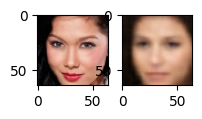

 15%|█▍        | 500/3434 [01:26<07:09,  6.83it/s]

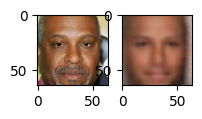

 29%|██▉       | 1000/3434 [02:49<06:08,  6.60it/s]

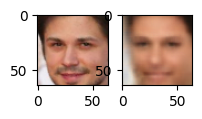

 44%|████▎     | 1500/3434 [04:15<04:38,  6.94it/s]

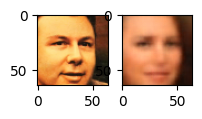

 58%|█████▊    | 2000/3434 [05:40<03:50,  6.23it/s]

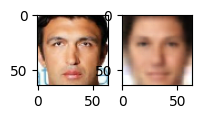

 73%|███████▎  | 2500/3434 [07:06<02:44,  5.68it/s]

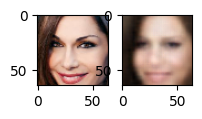

 87%|████████▋ | 3000/3434 [08:30<01:05,  6.67it/s]

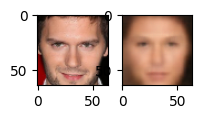

100%|██████████| 3434/3434 [09:42<00:00,  5.90it/s]


In [17]:
batch_size = 32
learning_rate = 5e-4
latent_dim = 32
num_epochs = 6

ss_vae = SS_VAE(latent_dim)
optimizer = tf.keras.optimizers.Adam(learning_rate)

@tf.function
def ss_vae_train_step(x, y):

  with tf.GradientTape() as tape:
    y_logit, z_mean, z_logsigma, x_recon = ss_vae(x)

    loss, class_loss, _ = ss_vae_loss_function(x, x_recon, y, y_logit, z_mean, z_logsigma)

  grads = tape.gradient(loss, ss_vae.trainable_variables)
  optimizer.apply_gradients(zip(grads, ss_vae.trainable_variables))
  return loss

all_faces = loader.get_all_train_faces()

if hasattr(tqdm, '_instances'): tqdm._instances.clear() # clear if it exists

for i in range(num_epochs):

  IPython.display.clear_output(wait=True)
  print("Starting epoch {}/{}".format(i+1, num_epochs))

  for j in tqdm(range(loader.get_train_size() // batch_size)):
    (x, y) = loader.get_batch(batch_size)
    loss = ss_vae_train_step(x, y)

    if j % 500 == 0:
      mdl.util.plot_sample(x, y, ss_vae)

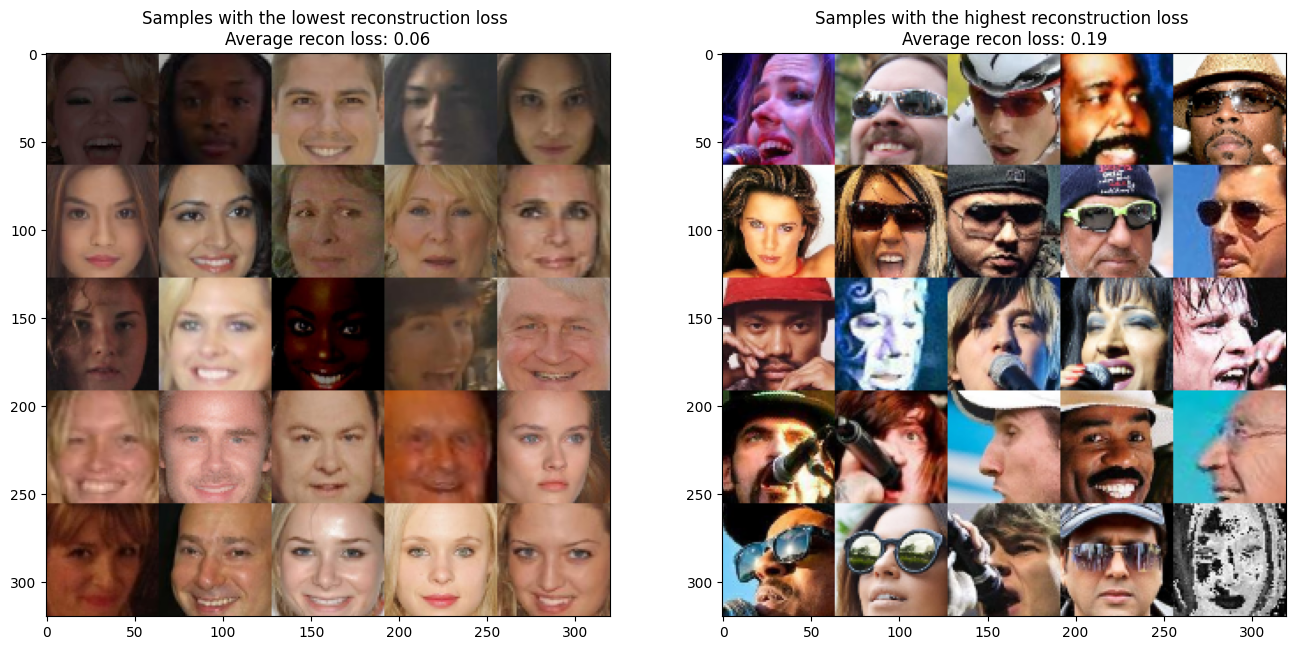

In [18]:
(x, y) = loader.get_batch(5000, only_faces=True)
y_logit, z_mean, z_logsigma, x_recon = ss_vae(x)
loss, class_loss, vae_loss = ss_vae_loss_function(x, x_recon, y, y_logit, z_mean, z_logsigma)

vae_loss = vae_loss.numpy()
ind = np.argsort(vae_loss, axis=None)

fig, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].imshow(mdl.util.create_grid_of_images(x[ind[:25]]))
ax[0].set_title("Samples with the lowest reconstruction loss \n" +
                f"Average recon loss: {np.mean(vae_loss[ind[:25]]):.2f}")

ax[1].imshow(mdl.util.create_grid_of_images(x[ind[-25:]]))
ax[1].set_title("Samples with the highest reconstruction loss \n" +
                f"Average recon loss: {np.mean(vae_loss[ind[-25:]]):.2f}");

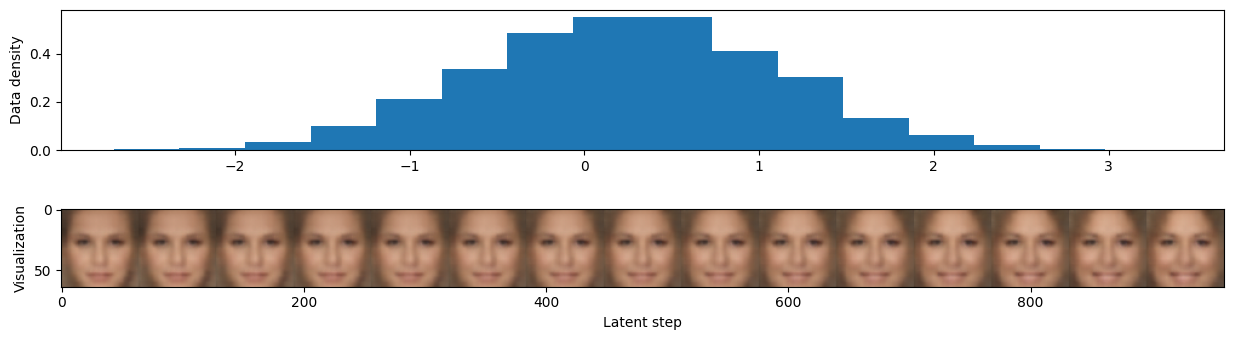

In [19]:
idx_latent = 8 #@param {type:"slider", min:0, max:31, step:1}
num_steps = 15

latent_samples = z_mean[:, idx_latent]

density, latent_bins = np.histogram(latent_samples, num_steps, density=True)
fig, ax = plt.subplots(2, 1, figsize=(15, 4))
ax[0].bar(latent_bins[1:], density)
ax[0].set_ylabel("Data density")

latent_steps = np.linspace(np.min(latent_samples), np.max(latent_samples), num_steps)
baseline_latent = tf.reduce_mean(z_mean, 0, keepdims=True)

recons = []
for step in latent_steps:
  latent = baseline_latent.numpy()
  latent[0, idx_latent] = step
  recons.append(ss_vae.decode(latent)[0])

ax[1].imshow(mdl.util.create_grid_of_images(recons, (1, num_steps)))
ax[1].set_xlabel("Latent step")
ax[1].set_ylabel("Visualization");


Text(0, 0.5, 'Relative accuracy')

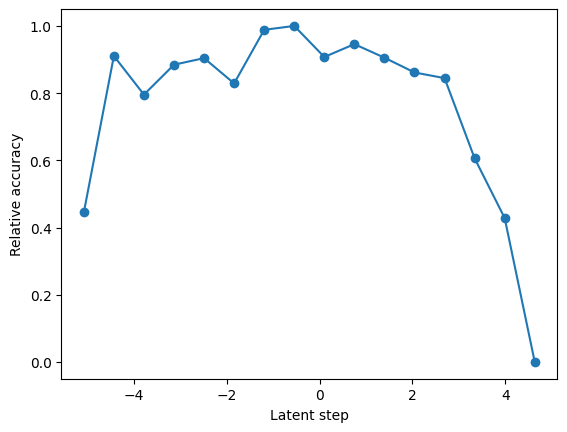

In [20]:
avg_logit_per_bin = []
for idx_latent in range(latent_dim):
  latent_samples = z_mean[:, idx_latent]
  start = np.percentile(latent_samples, 5)
  end = np.percentile(latent_samples, 95)
  latent_steps = np.linspace(start, end, num_steps)

  which_latent_bin = np.digitize(latent_samples, latent_steps)

  avg_logit = []
  for j in range(0, num_steps+1):
    inds_in_bin = np.where(which_latent_bin == j)
    avg_logit.append(y_logit.numpy()[inds_in_bin].mean())

  avg_logit_per_bin.append(avg_logit)

accuracy_per_latent = np.mean(avg_logit_per_bin, 0)
accuracy_per_latent = (accuracy_per_latent - accuracy_per_latent.min()) / np.ptp(accuracy_per_latent)

plt.plot(np.linspace(np.min(z_mean), np.max(z_mean), num_steps+1), accuracy_per_latent,'-o')
plt.xlabel("Latent step")
plt.ylabel("Relative accuracy")